In [1]:
"""Load in data associated with regression and analyze the distribution of angles over time in terms of lag/prediction"""

import numpy as np
import mne 
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
from scipy.stats import vonmises

subjects = [f"S{i:02}" for i in range(1, 21)]
#Set 1 if you want to include miniepochs with a pre-onset period
BaselineData = 1
#Set to 0 to look at data trained on the early peak response, 1 to look at data trained on late peak response
Peak = 0
if Peak == 0:
    timing = 'Early'
else:
    timing = 'Late'
bids_dir = '/System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/derivatives/preprocessed/'
data_path = f'/System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/!Important Data/errors/'
# Dictionary to store data for each subject
subject_data = {}

for Subject in subjects:
    if BaselineData == 1:
        fn_Subject = f'{Subject}_Errors{timing}BaselineIncluded.npy'
    else:
        fn_Subject = f'{Subject}_Errors{timing}.npy'
    if BaselineData == 1:
        fn_miniepochs = f'sub-{Subject}_miniEpochsBaselineIncluded_preprocessed-epo.fif'
    else:
        fn_miniepochs = f'sub-{Subject}_miniEpochs_preprocessed-epo.fif'
    epochs_mini = mne.read_epochs(bids_dir + fn_miniepochs)
    errors = np.load(data_path + 'data/' + fn_Subject)
    
    subject_data[Subject] = {
        'epochs_mini': epochs_mini,
        'errors': errors
    }

# Print shape and first few lines of errors arrays for comparison
for Subject in subjects:
    errors = subject_data[Subject]['errors']
    print(f"Subject {Subject}: Shape {errors.shape}")
    print(errors[:5])  # Print first 5 lines for inspection

Reading /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/derivatives/preprocessed/sub-S01_miniEpochsBaselineIncluded_preprocessed-epo.fif ...
    Found the data of interest:
        t =       0.00 ...      49.17 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
28672 matching events found
No baseline correction applied
0 projection items activated
Reading /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/derivatives/preprocessed/sub-S02_miniEpochsBaselineIncluded_preprocessed-epo.fif ...
    Found the data of interest:
        t =       0.00 ...      49.17 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
28672 matching events found
No baseline correction applied
0 projection items activated
Reading /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/derivatives/preprocessed/sub-S03_miniEpochsBaselineIncluded_preprocessed-epo.fif ...
    Foun

[-1 -2 -3 -4  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43
 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59]


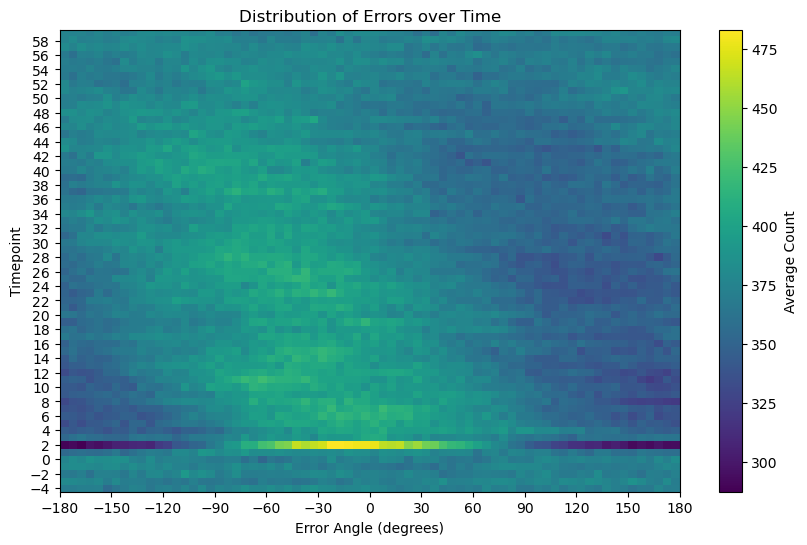

In [ ]:
# Step 1: Get all timepoints for miniepochs
all_timepoints = subject_data[subjects[0]]['epochs_mini'].metadata['timepoints'].unique()
print(all_timepoints)
all_timepoints = np.sort(all_timepoints)
num_timepoints = len(all_timepoints)
num_subjects = len(subject_data)
# Step 2: Create matrix
angle_error = np.arange(-180, 185, 5)  # Bin edges
hist_matrix = np.zeros((num_timepoints, len(angle_error) - 1))

# Step 3: Loop through timepoints and collect errors at that timepoint
for idx, tp in enumerate(all_timepoints):
    all_counts = np.zeros(len(angle_error) - 1)

    for subj in subject_data.keys():
        s_errors = subject_data[subj]["errors"]
        trialmat = subject_data[subj]["epochs_mini"].metadata

        time_idx = trialmat[trialmat.timepoints == tp].index.to_numpy()
        toplot = s_errors[time_idx, :].flatten()

        counts, _ = np.histogram(toplot, bins=angle_error)
        all_counts += counts

    hist_matrix[idx, :] = all_counts / num_subjects

# Step 4: Plot
plt.figure(figsize=(10, 6))
plt.imshow(hist_matrix, aspect="auto", cmap="viridis", 
           extent=[-180, 180, all_timepoints[0] - 0.5, all_timepoints[-1] + 0.5],
           origin="lower")
plt.colorbar(label="Average Count")
plt.xlabel("Error Angle (degrees)")
plt.ylabel("Timepoint")
plt.title("Distribution of Errors over Time")
plt.xticks(np.arange(-180, 181, 30))
plt.yticks(all_timepoints[::2])
plt.show()


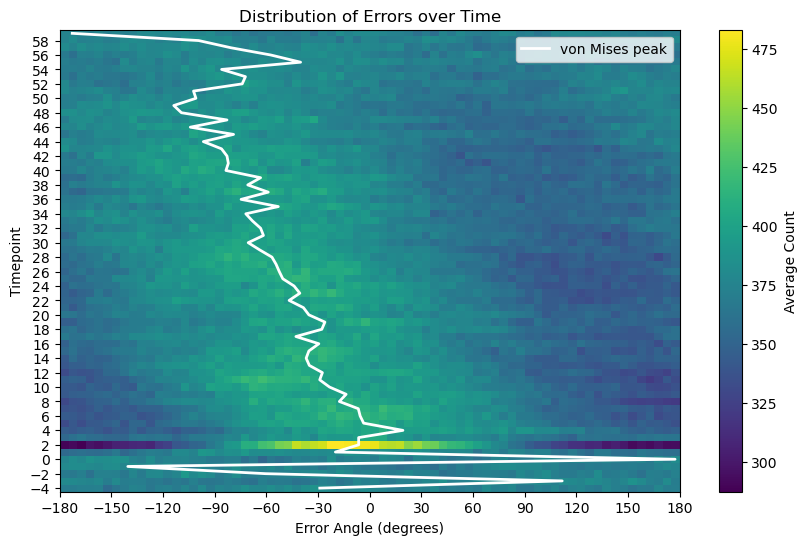

In [6]:
from scipy.stats import vonmises
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Get all timepoints for miniepochs
all_timepoints = subject_data[subjects[0]]['epochs_mini'].metadata['timepoints'].unique()
all_timepoints = np.sort(all_timepoints)
num_timepoints = len(all_timepoints)

# Step 2: Create matrix
hist_matrix = np.zeros((num_timepoints, len(angle_error) - 1))
peak_angles = np.zeros(num_timepoints)  # Second array to store peak angle at every timepoint as determined by von mises fit

# Step 3: Loop through timepoints and collect errors/peak angle at that timepoint
for idx, tp in enumerate(all_timepoints):
    all_angles = []

    for subj in subject_data.keys():
        s_errors = subject_data[subj]["errors"]
        trialmat = subject_data[subj]["epochs_mini"].metadata

        time_idx = trialmat[trialmat.timepoints == tp].index.to_numpy()
        toplot = s_errors[time_idx, :].flatten()
        all_angles.extend(toplot)

    all_angles = np.deg2rad(all_angles)  # convert to radians for von Mises

    # Histogram for the heatmap
    counts, _ = np.histogram(np.rad2deg(all_angles), bins=angle_error)
    hist_matrix[idx, :] = counts / num_subjects

    # Fit von Mises to get mean direction (peak angle)
    try:
        kappa, loc, scale = vonmises.fit(all_angles, fscale=1)
        peak_angles[idx] = np.rad2deg(loc)  # convert back to degrees
    except Exception as e:
        print(f"Fit failed at timepoint {tp}: {e}")
        peak_angles[idx] = np.nan

# Step 4: Plot
plt.figure(figsize=(10, 6))
plt.imshow(hist_matrix, aspect="auto", cmap="viridis", 
           extent=[-180, 180, all_timepoints[0] - 0.5, all_timepoints[-1] + 0.5],
           origin="lower")
plt.plot(peak_angles, all_timepoints, color='white', linewidth=2, label="von Mises peak")
plt.colorbar(label="Average Count")
plt.xlabel("Error Angle (degrees)")
plt.ylabel("Timepoint")
plt.title("Distribution of Errors over Time")
plt.xticks(np.arange(-180, 181, 30))
plt.yticks(all_timepoints[::2])
plt.legend()
plt.show()


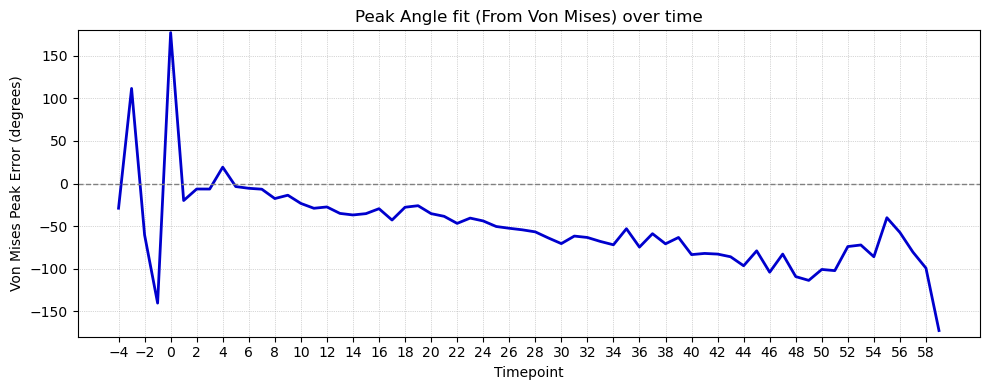

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Plot just Von Mises over time

plt.figure(figsize=(10, 4))
plt.plot(all_timepoints, peak_angles, color='mediumblue', linewidth=2)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.xlabel("Timepoint")
plt.ylabel("Von Mises Peak Error (degrees)")
plt.title("Peak Angle fit (From Von Mises) over time")
plt.xticks(all_timepoints[::2])  #Reduce tick clutter
plt.ylim(-180, 180)
plt.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()


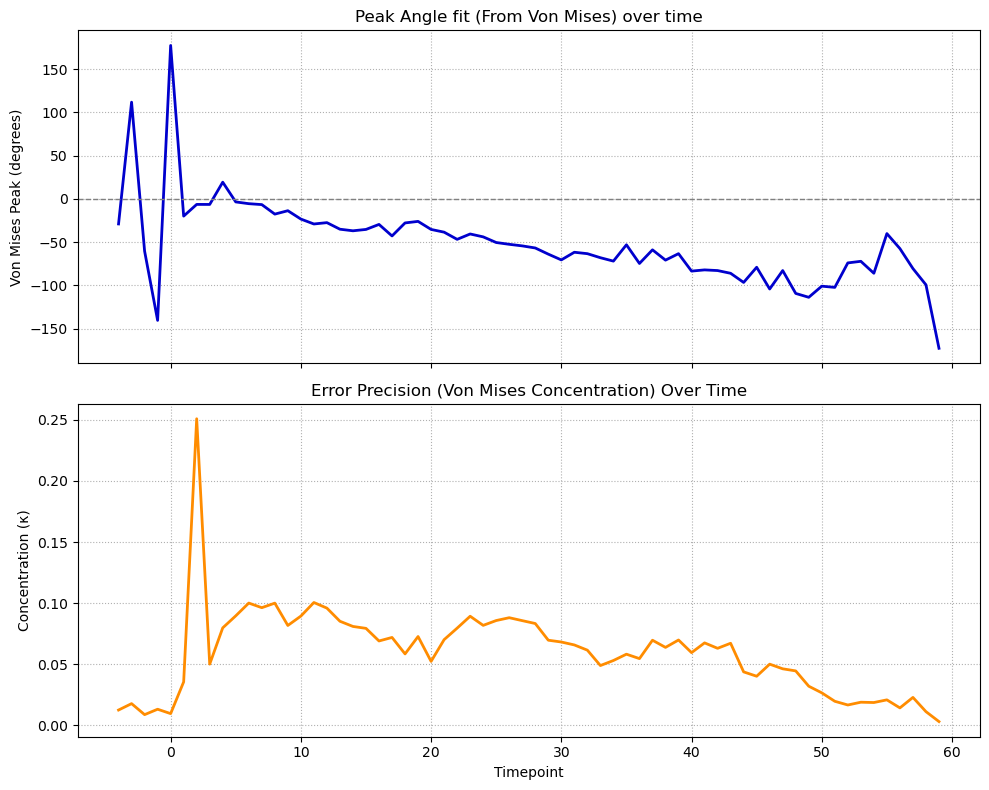

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import vonmises

# Assumes:
# - all_timepoints: sorted array of timepoints
# - subject_data[subj]["errors"]: trial-by-trial errors
# - subject_data[subj]["epochs_mini"].metadata["timepoints"]: time info

peak_angles = np.zeros(len(all_timepoints))
kappas = np.zeros(len(all_timepoints))

for idx, tp in enumerate(all_timepoints):
    all_angles = []

    for subj in subject_data.keys():
        s_errors = subject_data[subj]["errors"]
        trialmat = subject_data[subj]["epochs_mini"].metadata

        time_idx = trialmat[trialmat.timepoints == tp].index.to_numpy()
        toplot = s_errors[time_idx, :].flatten()
        all_angles.extend(toplot)

    all_angles = np.deg2rad(all_angles)

    try:
        kappa, loc, scale = vonmises.fit(all_angles, fscale=1)
        peak_angles[idx] = np.rad2deg(loc)
        kappas[idx] = kappa
    except Exception as e:
        peak_angles[idx] = np.nan
        kappas[idx] = np.nan
        print(f"Fit failed at timepoint {tp}: {e}")

# Kappa and Von Mises#
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Peak angle plot
axs[0].plot(all_timepoints, peak_angles, color='mediumblue', linewidth=2)
axs[0].axhline(0, color='gray', linestyle='--', linewidth=1)
axs[0].set_ylabel("Von Mises Peak (degrees)")
axs[0].set_title("Peak Angle fit (From Von Mises) over time")
axs[0].grid(True, linestyle=':')

# Kappa plot
axs[1].plot(all_timepoints, kappas, color='darkorange', linewidth=2)
axs[1].set_xlabel("Timepoint")
axs[1].set_ylabel("Concentration (κ)")
axs[1].set_title("Error Precision (Von Mises Concentration) Over Time")
axs[1].grid(True, linestyle=':')

plt.tight_layout()
plt.show()
